c:\Users\LWG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[[-1.83357642e-04 -1.49540400e-03]
 [-5.38608165e-04 -1.17312850e-03]
 [ 5.13690285e-04 -8.89549382e-04]
 [ 9.41522745e-04 -7.68726598e-04]
 [-2.36790314e-04 -1.15556917e-04]
 [ 1.28759180e-03 -1.20035424e-03]
 [-2.56796574e-04  6.62271467e-05]
 [-3.86089050e-04 -1.03640165e-03]
 [-4.67587073e-04 -2.43029648e-04]
 [ 2.88207789e-04 -7.39014793e-04]]


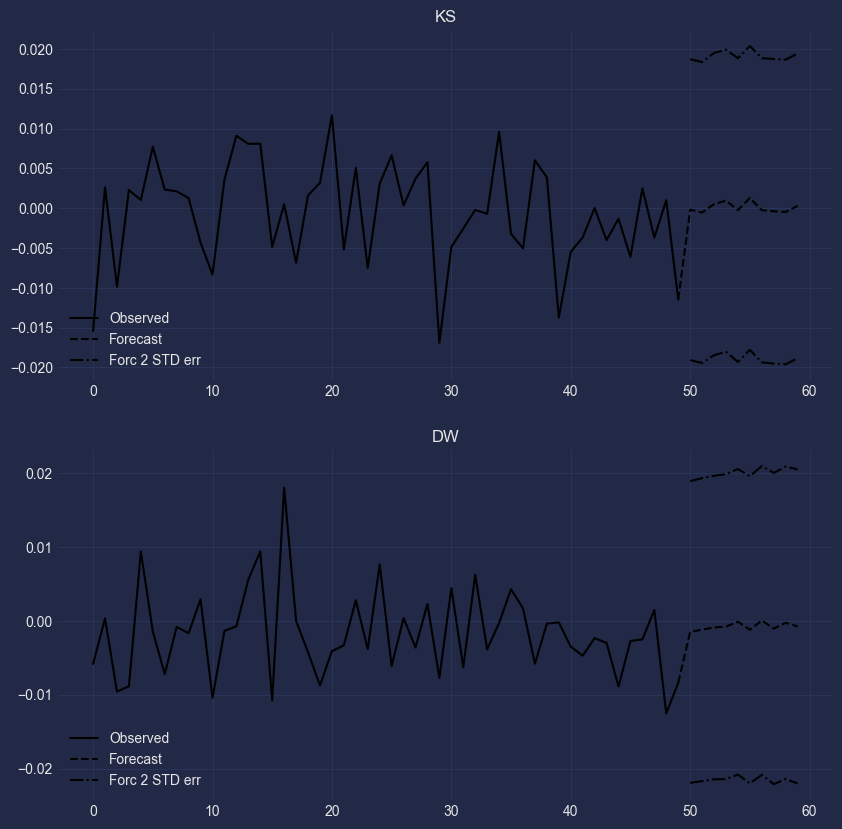

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Graph Style
import mplcyberpunk
plt.style.use('cyberpunk')

def readData(name):
    return pd.read_csv(name+".csv")

def madeData(name,df):
    temp = pd.DataFrame({'Date':KS['date'],'KS':KS['close'],name:df['close']})
    #inplace를 통해 기존의 인덱스(숫자)를 대체
    temp.set_index('Date',inplace=True)
    temp = temp.dropna()
    return temp

def showChart(df):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    #numpy 다차원 배열 공간을 1차원으로 평탄화해주는 함수 
    ax_li = axes.flatten()
    df_cols = df.columns
    for i, (col, ax) in enumerate(zip(df_cols, ax_li)):
        print(col,ax)
        ax.plot(df[col], linewidth=0.8)
        ax.set_title(col)

    plt.tight_layout()
    plt.show()
    
#정상성 분석 함수
def adf_test(data):
    data = pd.read_csv(data+".csv")
    from statsmodels.tsa.stattools import adfuller
    #axis=1은 열을 의미한다.
    #data = data.drop(['code'],axis=1) 
    data=data[['date','close']]
    #로그 변환 - 주가가 큰 폭으로 움직여서
    data['close']=np.log(data['close'])
    #print(data)
    result = adfuller(data['close'])
    #print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
    #print(f'원 데이터 p-value: {result[1]:.3f}')
    if(result[1]>0.05):
        #차분으로 추세제거
        data['close']=data['close'].diff(periods=1).iloc[1:]
        data=data.dropna()
        result = adfuller(data['close'])
        #print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
        #print(f'1차 차분 p-value: {result[1]:.10f}')
    #변환 후 반환
    return data
#그레인저 인과검정
def granger(df,data,data2):
    from statsmodels.tsa.stattools import grangercausalitytests
    df_cols = df.columns
    maxlag=14
    #KS->DW
    df_outs=grangercausalitytests(df[[data,data2]],maxlag=maxlag)
    print(df_outs)
    
    #DW->KS
    df_outs=grangercausalitytests(df[[data2,data]],maxlag=maxlag)
    print(df_outs)
    
def cointegration(KDW):
    from statsmodels.tsa.vector_ar.vecm import coint_johansen
    out = coint_johansen(KDW,1,1)
    #공적분 결과값이 해당 유의수준 통계량보다 크면 유의하다.
    stats = [round(x,2) for x in out.lr1] #공적분 통계량
    sigs = [round(x,2) for x in out.cvt[:, 1]] #유의수준 0.05 관측치
    yns = [x>y for x,y in zip(stats,sigs)] # 유의 여부(장기 안정성)
    dist = np.mean(np.array(stats) - np.array(sigs)) #안정성의 강도
    print('stats: ',stats) 
    print('sig-level: ',sigs)
    print('significant_yn: ',[x>y for x,y in zip(stats,sigs)])
    print('dist: ', round(dist,2))

def var_model(df):
    from statsmodels.tsa.api import VAR
    from statsmodels.stats.stattools import durbin_watson
    model = VAR(df)
    model = model.fit(3)
    print(model.summary())
    durbin = pd.DataFrame([model.resid.columns, 
                           [round(x,2) for x in durbin_watson(model.resid)]]).T
    durbin = durbin.set_index([0])

def vecm_model(df):
    from statsmodels.tsa.vector_ar import vecm 
    vmodel = vecm.VECM(endog = df, k_ar_diff = 9, coint_rank = 3, deterministic = 'ci')
    model_fit = vmodel.fit()
    print(model_fit.predict(steps=10))
    model_fit.plot_forecast(steps=10, n_last_obs=50)

KS=adf_test("KS")
DW=adf_test("DW")
#KS=readData("KS")
#DW=readData("DW")
KDW = madeData("DW",DW)
vecm_model(KDW)
#cointegration(KDW)
#granger(KDW,"KS","DW")
#showChart(KDW)
#granger(KDW)
#KSP = madeData("SP")
#showChart(KSP)
#KNS = madeData("NS")
#showChart(KNS)